Travaux pratiques pour modéliser un système de communication

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.channels import awgn
from commpy.filters import  rrcosfilter, rcosfilter

In [331]:
M = 2               # Size of the signal constellation
k = int(np.log2(M)) # Number of bits per symbol
sps = 100           # Samples per symbol
N = 100             # Number of data bits

alpha = 0.25
sps = 100
nTaps = 1000
ts = 1
fs = sps / ts

Constantes

Transmitter
To do :
1. Allocate data to each level ([1, -1] or [1,0.33,-0.33,-1])
2. Upsample with zeros
2. Generate pulse (RRC) and plot
3. Apply pulse shapping (convolve)
4. Plot

In [332]:
def convertLevel(numberLevel, N, k):
    data = np.random.randint(M, size=int(N/k))
    if numberLevel == 2:
      dataReturn = np.where(data == 0, -1, 1)

    elif numberLevel == 4:
        mapping = {
        0: 1,
        1: 0.33,
        2: -0.33,
        3: -1
    	}
        dataReturn = np.array([mapping[val] for val in data])
    else :
      print("Number of level not supported")
      return None

    return dataReturn


def upSsample(data, sps, mode):

    if mode == 0:
        data_up = np.zeros(len(data) * (sps + 1) - sps)
        data_up[::sps + 1] = data
        #data = data_up
    elif mode == 1:
      data_up = np.repeat(data, sps)
    return data_up

def upsample(data, L, mode='zero'):
    upsampled_length = len(data) * L
    
    upsampled_data = np.zeros(upsampled_length)
    
    if mode == 'zero':
        upsampled_data[::L] = data
    elif mode == 'replicate':
        for i in range(len(data)):
            upsampled_data[i*L:(i+1)*L] = data[i]
    return upsampled_data

myDatas = upsample(convertLevel(M, N, k), sps)


10000


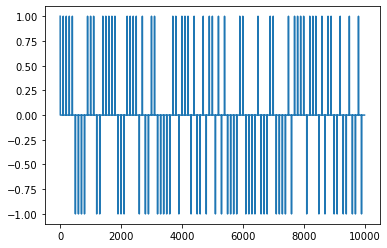

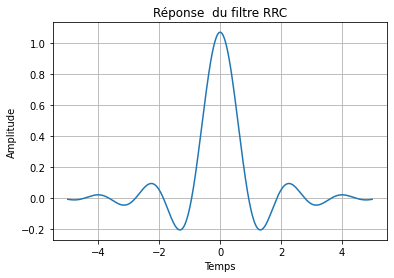

In [333]:
print(myDatas.size)
plt.plot(myDatas)
plt.show()
time, dataFiltered = rrcosfilter(nTaps, alpha, 1,sps)


plt.plot(time, dataFiltered)
plt.title('Réponse  du filtre RRC')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()




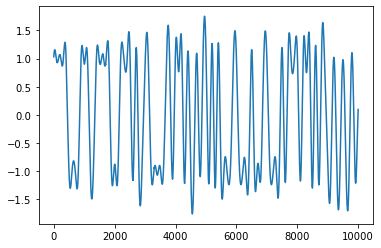

In [334]:
#Show convolution

txSig = np.convolve(myDatas, dataFiltered, mode="same")
plt.plot(txSig)

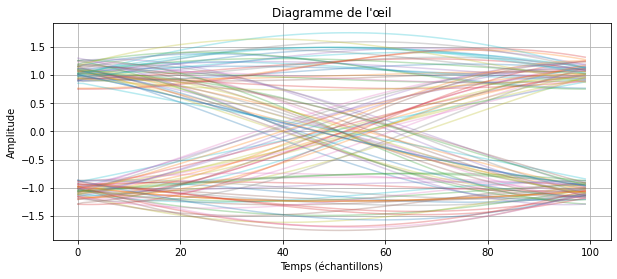

In [335]:
#Eye diagram
eyeData = []
num_eyes = 50

def plot_eye_diagram(signal, sps, n_periods=1):
    samples_per_period = sps
    n_symbols = len(signal) // samples_per_period
    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(n_symbols - n_periods):
        segment = signal[i * samples_per_period:(i + n_periods) * samples_per_period]
        ax.plot(segment, alpha=0.3)

    ax.set_title("Diagramme de l'œil")
    ax.set_xlabel("Temps (échantillons)")
    ax.set_ylabel("Amplitude")
    plt.grid(True)
    plt.show()

plot_eye_diagram(txSig, sps)

Channel

In [336]:
EbNo = 25;   #en dB
snr = EbNo + 10*np.log10(k) - 10*np.log10(0.5*sps); #snr: S/N per sample in dB
rxSig = awgn(txSig, snr)

Receiver
To do:
1. Apply RRC again
2. Take a sample every Tb
3. Decide if it is [1, -1] (M=2) or [1,0.33,-0.33,1] (M=4)

In [337]:
def decide(samples, M):
    """
    Cette fonction prend une décision en fonction des niveaux de modulation.
    Elle utilise np.digitize pour classer les échantillons.
    """
    if M == 2:
        levels = [-1, 1]
        thresholds = [0]
        decisions = np.digitize(samples, thresholds)
        return np.array([levels[decision] for decision in decisions])

    elif M == 4:
        levels = [-1, -0.33, 0.33, 1]
        thresholds = [-0.5, 0, 0.5]
        decisions = np.digitize(samples, thresholds)
        return np.array([levels[decision] for decision in decisions])

    else:
        raise ValueError("Modulation M non supportée")

def interpret(samples, M):
    """
    Cette fonction interprète les symboles en bits selon la modulation M-aire.
    """
    if M == 2:
        return np.where(samples < 0, 0, 1)

    elif M == 4:
        levels = [-1, -0.33, 0.33, 1]
        return np.digitize(samples, [-0.5, 0, 0.5])

    else:
        raise ValueError("Modulation M non supportée")


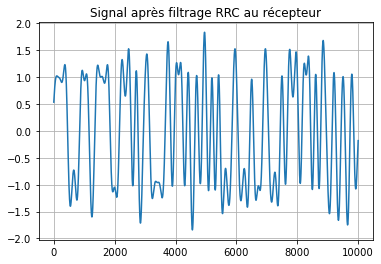

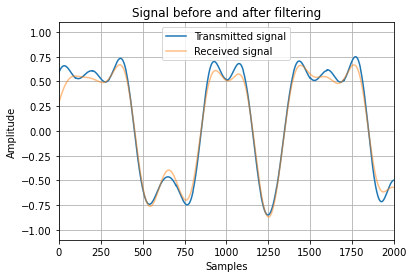

In [338]:

t, rrc_pulse = rrcosfilter(nTaps, alpha, ts, sps)


rrc_pulse = rrc_pulse / np.sum(rrc_pulse)


filtered_rxSig = np.convolve(rxSig, rrc_pulse, mode='same')


plt.plot(filtered_rxSig)
plt.title('Signal après filtrage RRC au récepteur')
plt.grid(True)
plt.show()


txSig_normalized = txSig / np.max(np.abs(txSig))
rxSig_normalized = filtered_rxSig / np.max(np.abs(filtered_rxSig))


plt.figure()
plt.plot(txSig_normalized, label='Transmitted signal')
plt.plot(rxSig_normalized, label='Received signal', alpha=0.5)
plt.title('Signal before and after filtering')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.xlim(0, 20 * sps)
plt.legend()
plt.grid(True)
plt.show()





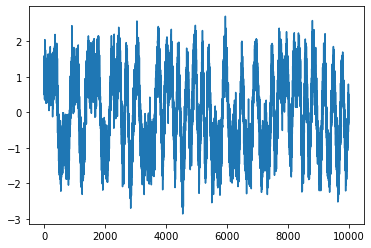

In [339]:
plt.plot(rxSig)

BER
To do:
1. Compare input with output, compute BER
2. Add a loop to vary Eb/N0 from 0 to 10dB by step of 0.1 dB
3. Plot BER vs. Eb/N0 curve

In [340]:
from scipy.special import erfc

def compute_ber_ask(Eb_N0_dB, M):
    Eb_N0 = 10**(Eb_N0_dB / 10)  # Convertir Eb/N0 de dB en échelle linéaire
    k = np.log2(M)  # Nombre de bits par symbole
    return (1/k) * ((M - 1) / M) * erfc(np.sqrt((3 / (M**2 - 1)) * Eb_N0 * k))



[0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0
 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1
 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1]
[-1 -1  1 -1  1 -1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1  1 -1  1
 -1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1
 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1 -1
 -1 -1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1  1 -1  1  1  1
  1 -1 -1  1]


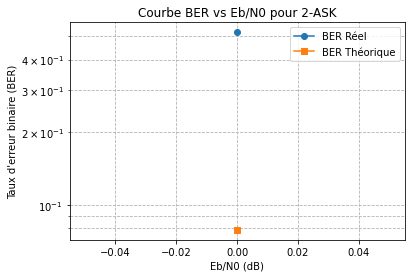

[1 3 0 2 0 2 3 1 1 2 2 2 0 3 3 0 0 0 0 3 0 0 0 3 0 1 3 3 0 2 3 2 3 2 3 2 3
 1 0 0 2 0 0 3 0 3 3 2 0 3]
[-1.    0.33 -1.    0.33 -0.33  0.33  1.   -0.33 -0.33  1.    0.33  1.
 -1.    1.    1.   -1.   -0.33 -1.   -0.33  1.   -0.33 -1.   -0.33  0.33
 -0.33 -0.33  1.    0.33 -1.    0.33  1.    0.33  0.33  0.33  1.   -0.33
  1.   -0.33  0.33 -0.33 -0.33 -1.   -1.    1.   -1.    0.33  0.33  0.33
 -1.    0.33]


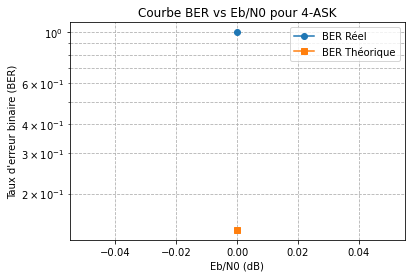

In [341]:
import matplotlib.pyplot as plt
import numpy as np


# Boucle pour calculer le BER pour M = 2 et M = 4
Eb_N0_dB_range = np.arange(0, 1, 1)
for M in [2, 4]:
    BER_real = []
    BER_theoretical = []

    k = int(np.log2(M))

    data_tx = convertLevel(M, N, k)


    upsampled_data = upsample(data_tx, sps)


    t_rrc, rrc_pulse = rrcosfilter(nTaps, alpha, ts, sps)
    txSig = np.convolve(upsampled_data, rrc_pulse, mode='same')

    for Eb_N0_dB in Eb_N0_dB_range:

        snr = Eb_N0_dB + 10*np.log10(k) - 10*np.log10(0.5 * sps)  #
        channelSig = awgn(txSig, snr)

        rxSig = np.convolve(channelSig, rrc_pulse, mode='same')

        rxSig = rxSig / sps

        downsampled_data = rxSig[::sps]

        data_decide = decide(downsampled_data, M)

        data_rx = interpret(data_decide, M)

        min_length = min(len(data_rx), len(data_tx))


        data_rx = data_rx[:min_length]
        print(data_rx)
        data_tx = data_tx[:min_length]
        print(data_tx)

        bit_errors = np.sum(np.array(data_rx) != data_tx)
        ber_real = bit_errors / len(data_tx)
        BER_real.append(ber_real)


        ber_theoretical = compute_ber_ask(Eb_N0_dB, M)
        BER_theoretical.append(ber_theoretical)

    # Tracer les courbes BER vs. Eb/N0
    plt.figure()
    plt.semilogy(Eb_N0_dB_range, BER_real, label='BER Réel', marker='o')
    plt.semilogy(Eb_N0_dB_range, BER_theoretical, label='BER Théorique', marker='s')
    plt.title('Courbe BER vs Eb/N0 pour {}-ASK'.format(M))
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taux d\'erreur binaire (BER)')
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()


*Note de fin de labo:* J'ai trouvé en ligne on peut calculer le ber theorique. Il y a plusieurs formule entre BPSK ou ASK. J'ai pas tout compris ce que ça signifie.
Je comprends pas vraiment ce qui fait que le ber calculé est tout droit
comme on peut le voir. Je suis pas sure de savoir ce qui est faux et je comprends pas non plus tout ce que j'ai fait....

In [342]:
print(BER_real)

[1.0]
